<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd

from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
import nltk
nltk.download('stopwords') 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
df['toxic'].unique()

array([0, 1])

In [7]:
df.duplicated().unique()

array([False])

<AxesSubplot:title={'center':'Тональность комментариев'}, ylabel='Тональность'>

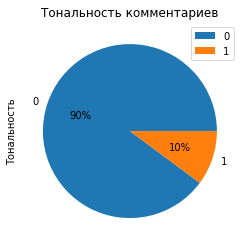

In [8]:
df['toxic'].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тональность комментариев', legend = True, ylabel = 'Тональность')

Был проведён первичный осмотр и анализ данных. Никаких выбросов не обнаружено, в целевом столбце все значения либо 0, либо 1. Явных дубликатов тоже нет

In [9]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def lemmatize(text):
    m = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    return ' '.join([m.lemmatize(i, get_wordnet_pos(i)) for i in text])

In [11]:
tqdm.pandas()
df['new_text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
df.head(10)

,text,toxic,new_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not try to edit war it's ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word 'nonsense' be offensive to y...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Была проведена лемматизация текста и очистка от регулярных выражений.

В рамках данного этапа были осмотрены данные, проведена их подготовка к дальнейшей работе

## Обучение

In [13]:
y = df['toxic']
X = df.drop(['toxic'], axis = 1)
RANDOM_STATE = 45
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    ) 

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(X_train['new_text']) 

In [16]:
test_tf_idf = count_tf_idf.transform(X_test['new_text'])

In [17]:
pipe_final= Pipeline([
    ('models', LogisticRegression())
])

In [18]:
param_distributions = [
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l2'],
        'models__C': [0.1, 1, 10, 100]
    },
    {
        'models': [LogisticRegression()],
        'models__penalty': ['none']
    },
    {
        'models': [CatBoostClassifier(random_state = RANDOM_STATE)],
        'models__iterations': [range(100, 601, 100)]
    }
] 

In [19]:
search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring='f1', 
    n_jobs=-1
)
search.fit(tf_idf, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=5, estimator=Pipeline(steps=[('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(C=10)],
                          'models__C': [0.1, 1, 10, 100],
                          'models__penalty': ['l2']},
                         {'models': [LogisticRegression()],
                          'models__penalty': ['none']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f1c265947f0>],
                          'models__iterations': [range(100, 601, 100)]}],
             scoring='f1')

In [20]:
new_predict = search.predict(test_tf_idf)

In [21]:
f1_score(y_test, new_predict)

0.7745358090185676

Значение метрики удовлетворяет условию

In [22]:
search.best_estimator_

Pipeline(steps=[('models', LogisticRegression(C=10))])

В рамках данного этапа были обучены модели и проведён подбор гиперпараметров

## Выводы

Передо мной стояла задача обучить модель классифицировать комментарии на позитивные и негативные. В моём распоряжении был набор данных с разметкой о токсичности правок. Для начала была произведена подготовка данных: лемматизация текста и очистка от регулярных выражений. Далее написан пайплан для перебора двух моделей и гиперпараметров к ним. Лучшей моделью оказалась `LogisticRegression(C=10, penalty='l1', solver='saga')`. Значение метрики 0.77, что удовлетворяет условию

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны